# Brechas de ingresos entre mujeres y hombres

> Una exploración rápida entre brechas de ingresos con datos de la [Encuesta Contínua de Empleo](https://www.ine.gob.bo/index.php/metadatos-y-microdatos/) publicada por el INE.

In [2]:
import pandas as pd
import pdfplumber
import re
from collections import ChainMap
import json
import datetime as dt
import geopandas as gpd;
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
from matplotlib import font_manager
import numpy as np
from textwrap import wrap

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
plt.style.use('publish/estilo.mplstyle')

In [6]:
def get_caeb(pdf_filename):
    
    pdf = pdfplumber.open(pdf_filename)
    caeb = {}
    for i, page in enumerate(pdf.pages[28:62]):
        rows = page.extract_text().split('\n')
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCIÓN' in row][0]:-1]
        for row in rows:
            categoria = re.findall('^[A-Z]\s\s\s\s+', row)
            if len(categoria) > 0:
                cat = categoria[0].strip()
                caeb[cat] = []
            actividad = re.findall('[0-9]+', row)
            if len(actividad) > 0:
                caeb[cat].append(actividad[0])

    actividades = [{actividad:key for actividad in caeb[key]} for key in caeb.keys()]
    actividades = dict(ChainMap(*actividades))
    caeb = {**actividades, **{key:key for key in caeb.keys()}}

    return caeb

def diccionarios():
    
    actividades = {
        'A': 'agricultura, ganadería, caza , pesca y silvicultura',
        'B': 'explotación de minas y canteras',
        'C': 'industria manufacturera',
        'D': 'suministro de electricidad, gas, vapor y aire acondicionado',
        'E': 'suministro de agua; evacuación de aguas residuales, gestión de desechos y descontaminación',
        'F': 'construcción',
        'G': 'venta por mayor y por menor; reparación de vehículos automotores y motocicletas',
        'H': 'transporte y almacenamiento',
        'I': 'actividades de alojamiento y servicio de comidas',
        'J': 'información y comunicaciones',
        'K': 'intermediación financiera y seguros',
        'L': 'actividades inmobiliarias',
        'M': 'servicios profesionales y técnicos',
        'N': 'actividades de servicios administrativos y de apoyo',
        'O': 'administración pública, defensa y planes de seguridad social de afiliación obligatoria',
        'P': 'servicios de educación',
        'Q': 'servicios de salud y de asistencia social',
        'R': 'actividades artísticas, de entretenimiento y recreativas',
        'S': 'otras actividades de servicios',
        'T': 'actividades de hogares privados como empleadores',
        'U': 'servicios de organizaciones y órganos extraterritoriales'
    }

    niveles_educativos = {
        10: 'ninguno y no sabe leer y escribir',
        11: 'ninguno pero sabe leer y escribir',
        12: 'programa de alfabetización',
        13: 'educación inicial o pre-escolar (pre kinder/kinder)',
        21: 'sistema escolar antiguo - básico (1 a 5 años)',
        22: 'sistema escolar antiguo - intermedio (1 a 3 años)',
        23: 'sistema escolar antiguo - medio (1 a 4 años)',
        31: 'sistema escolar anterior - primaria (1 a 8 años)',
        32: 'sistema escolar anterior - secundaria (1 a 4 años)',
        41: 'sistema escolar actual - primaria (1 a 6 años)',
        42: 'sistema escolar actual - secundaria (1 a 6 años)',
        51: 'educación de adultos (sistema antiguo) - educación básica de adultos (eba)',
        52: 'educación de adultos (sistema antiguo) - centro de educación media de adultos (cema)',
        61: 'educación alternativa y especial - educación juvenil alternativa (eja)',
        62: 'educación alternativa y especial - educación primaria para adultos (epa)',
        63: 'educación alternativa y especial - educación secundaria para adultos (esa)',
        64: 'educación alternativa y especial - programa nacional de post alfabetización',
        65: 'educación alternativa y especial - educación especial',
        71: 'educación superior - normal (escuela sup. de formación de maestros)',
        72: 'educación superior - universidad pública (licenciatura)',
        73: 'educación superior - universidad privada (licenciatura)',
        74: 'educación superior - postgrado diplomado',
        75: 'educación superior - postgrado maestría',
        76: 'educación superior - postgrado doctorado',
        77: 'educación superior - técnico de universidad',
        78: 'técnico de instituto (duración mayor o igual a 1 año)',
        79: 'institutos de formación militar y policial',
        80: 'educación técnica de adultos (eta)',
        81: 'otros cursos (duración menor a 1 año)'
    }

    deptos = {
        1: 'Chuquisaca',
        2: 'La Paz',
        3: 'Cochabamba',
        4: 'Oruro',
        5: 'Potosí',
        6: 'Tarija',
        7: 'Santa Cruz',
        8: 'Beni',
        9: 'Pando'
    }
    
    caeb = get_caeb('data/CAEB_2011.pdf')
    municipios = pd.read_csv('data/municipios.csv', index_col='cod_ine').municipio
    ocupaciones = load_ocupaciones()
    
    return caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones

def get_data():
    
    def parse_nacimiento(x):
        if x[0] != ' ':
            try:
                return dt.datetime.strptime('{}-{}-{}'.format(x[0], x[1], x[2]), '%Y-%m-%d')
            except Exception as e:
                return None
        else:
            return None


    column_filter = ['gestion', 'trimestre', 'depto', 'area', 's1_02', 's1_03ba', 's1_03bb', 's1_03bc', 's1_07a', 'aestudio', 'niv_ed', 's2_01', 's2_14', 's2_39deptocod', 's2_16acod', 's2_15acod', 'phrs', 's2_19a_t', 's2_19a_p', 's2_23', 's2_26', 's2_33_v', 's2_33_f', 's2_38_v', 's2_38_f']
    column_names = ['año', 'trimestre', 'dep', 'area', 'sexo', 'nacimiento_dia', 'nacimiento_mes', 'nacimiento_año', 'educacion', 'años_estudio', 'nivel_educativo', 'trabaja_semana', 'trabaja', 'municipio', 'actividad', 'ocupacion', 'horas_semana', 'tiempo', 'tiempo_unidad', 'nit', 'tamaño_empresa', 'salario', 'salario_frecuencia', 'ingreso', 'ingreso_frecuencia']
    dfi = pd.read_csv('data/encuesta_trabajo/ECE_4T15_1T21.csv', encoding='ISO-8859-1', delimiter=';', usecols=column_filter)[column_filter]
    dfi.columns = column_names
    dfi['año'] = dfi['año'].astype(int)
    dfi['trimestre'] = dfi['trimestre'].astype(int)
    dfi['dep'] = dfi.dep.map(deptos)
    dfi['area'] = dfi['area'].map({1: 'urbana', 2: 'rural'})
    dfi['sexo'] = dfi['sexo'].map({1: 'hombre', 2: 'mujer'})
    dfi.insert(5, 'nacimiento', dfi[['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia']].apply(lambda x: parse_nacimiento(x), axis=1))
    dfi.drop(columns=['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia'], inplace=True)
    dfi['educacion'] = dfi.educacion.apply(lambda x: int(x) if x != ' ' else None).map(niveles_educativos)
    dfi['años_estudio'] = pd.to_numeric(dfi.años_estudio, errors='coerce')
    dfi['nivel_educativo'] = pd.to_numeric(dfi.nivel_educativo, errors='coerce').map({0: 'ninguno', 1.0: 'primaria incompleta', 2.0: 'primaria completa', 3.0:'secundaria incompleta', 4.0:'secundaria completa', 5.0:'superior', 7.0:'otro'})
    dfi['trabaja_semana'] = dfi.trabaja_semana.map({'1': 'si', '2': 'no'})
    dfi['trabaja'] = dfi.trabaja.map({'1': 'si', '2': 'no'})
    dfi['municipio'] = pd.to_numeric(dfi.municipio, errors='coerce')
    dfi['actividad'] = dfi['actividad'].map(caeb).map(actividades)
    dfi['ocupacion'] = dfi['ocupacion'].map(ocupaciones)
    dfi['horas_semana'] = pd.to_numeric(dfi.horas_semana, errors='coerce')
    dfi['tiempo_unidad'] = pd.to_numeric(dfi.tiempo_unidad, errors='coerce').map({2: 1/53, 4: 1/12, 8: 1})
    dfi['tiempo'] = pd.to_numeric(dfi.tiempo, errors='coerce') * dfi.tiempo_unidad
    dfi.drop(columns=['tiempo_unidad'], inplace=True)
    dfi['nit'] = dfi.nit.map({'1': 'regimen general', '2': 'regimen simplificado', '3': 'no tiene'})
    dfi['tamaño_empresa'] = pd.to_numeric(dfi.tamaño_empresa, errors='coerce')
    dfi['salario'] = pd.to_numeric(dfi.salario, errors='coerce')
    dfi['salario_frecuencia'] = pd.to_numeric(dfi.salario_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
    dfi['salario'] = dfi.salario * dfi.salario_frecuencia
    dfi.drop(columns=['salario_frecuencia'], inplace=True)
    dfi['ingreso'] = pd.to_numeric(dfi.ingreso, errors='coerce')
    dfi['ingreso_frecuencia'] = pd.to_numeric(dfi.ingreso_frecuencia, errors='coerce').map({1.0: 1.0, 2.0: 1/7, 3.0: 1/15, 4.0: 1/30, 5.0: 1/60, 6.0:1/90, 7.0:1/180, 8.0:1/365})
    dfi['ingreso'] = dfi.ingreso * dfi.ingreso_frecuencia
    dfi.drop(columns=['ingreso_frecuencia'], inplace=True)
    
    return dfi

def get_mapa():
    mapa = gpd.read_file('data/fondos municipal.geojson')
    lagos = mapa[mapa.MUNICIPIO == ''].set_index('id').geometry
    mapa = mapa[mapa.MUNICIPIO != '']
    mapa['c_ut'] = mapa.c_ut.astype(int)
    mapa = mapa.set_index('c_ut').geometry
    return mapa, lagos

def load_ocupaciones():
    with open('data/encuesta_trabajo/ocupaciones.json', 'r') as f:
        return {i['value']: i['labl'] for i in json.load(f)['var_catgry']}

def muestra_ocupacion(dfi, col, min_sample):
    """
    Devuelve una lista de ocupaciones donde existen al menos
    `min_sample` número de muestras para cada valor posible en
    la columna `col`.
    """
    
    dfi = dfi.groupby(['ocupacion', col]).size().reset_index(name='muestra').pivot_table(index='ocupacion', columns=col, values='muestra')
    return dfi[(dfi >= min_sample).sum(axis=1) == 2].index.tolist()

def diferencia_sexo(años, min_sample):
    """
    Construye una tabla con la diferencia entre el ingreso neto diario 
    promedio de hombres y mujeres por ocupación. Sólo considera ocupaciones
    donde existen existen al menos `min_sample` número de muestras para
    tanto hombres como mujeres.
    """
    
    dfi = df[(df.ocupacion.notna()) & (df.sexo.notna()) & (df.ingreso.notna()) & (df.año.isin(años))]
    muestra = muestra_ocupacion(dfi, 'sexo', min_sample)
    dfi = dfi.groupby(['ocupacion', 'sexo']).ingreso.mean().reset_index().pivot_table(index='ocupacion', columns='sexo', values='ingreso')
    dfi['diferencia'] = dfi.mujer / dfi.hombre
    return dfi.loc[muestra].sort_values('diferencia', ascending=False)

def plot_ingreso_ocupacion_mujeres(ax, years):
    
    dsexo = diferencia_sexo(years, 10)
    ocupacion_mujeres = ocupacion_porcentaje_mujeres(years)
    
    lincolor='#88888f'
    dfi = pd.concat([dsexo.diferencia, ocupacion_mujeres], axis=1).dropna()
    dfi.columns = ['diferencia_ingreso', 'ocupacion']
    ax.scatter(dfi.diferencia_ingreso, dfi.ocupacion, color='#c0edd5', edgecolor=lincolor, linewidth=.8, alpha=.8, s=30)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    ax.tick_params(which='major', labelcolor=lincolor)
    ax.set_ylim(0,1)
    ax.grid()
    ax.axvline(1, color=lincolor, linewidth=.7, linestyle='--')

def ocupacion_porcentaje_mujeres(years):
    oc = df[(df.sexo.notna()) & (df.año.isin(years))].groupby(['ocupacion', 'sexo']).size().reset_index(name='muestra').pivot_table(index='ocupacion', columns='sexo', values='muestra').fillna(0)
    return oc.div(oc.sum(axis=1), axis=0).mujer

In [ ]:
caeb, actividades, niveles_educativos, deptos, municipios, ocupaciones = diccionarios()
df = get_data()

**En ocupaciones donde se contrata a más mujeres, ellas ganan menos que hombres. Este patrón ha cambiado poco en los últimos 5 años.** El siguiente gráfico muestra la relación entre el porcentaje de fuerza laboral femenina y el ingreso neto promedio de mujeres como porcentaje del ingreso de hombres, para cada ocupación con al menos 10 observaciones para mujeres y hombres. Las líneas muestran la trayectoria entre el valor del primer (2015 a 2017) y segundo periodo (2018 a 2020). Puntos rojos y verdes representan retrocesos y avances en ingresos relativos respectivamente, y su tamaño corresponde al número de trabajadoras mujeres. Las barras hacen fácil observar la distribución general de ambas variables en ambos periodos, donde barras delgadas y gruesas representan el primer y segundo periodo respectivamente. 

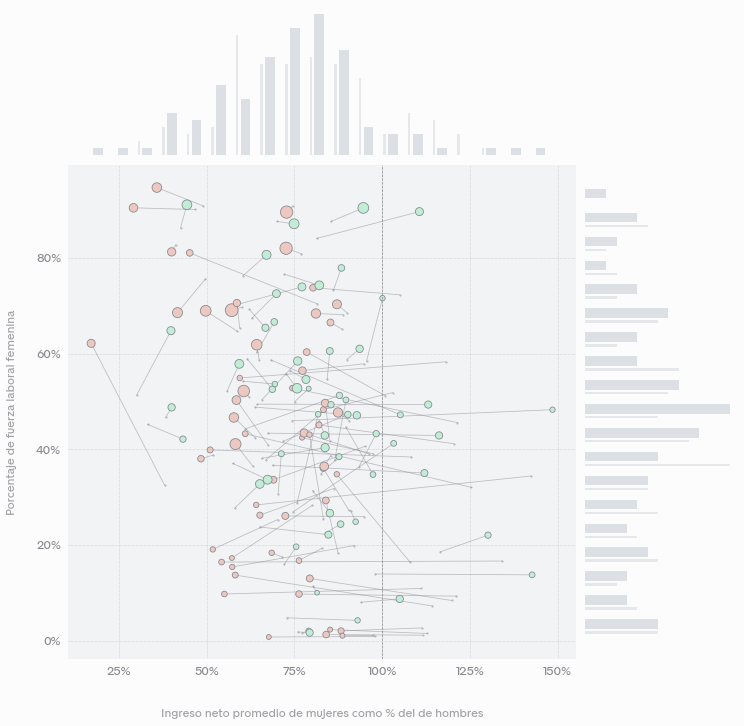

In [9]:
def plot_ocupaciones_mujeres_cambio():
    
    background = '#fcfcfc'
    
    def main_scatter(ax, dfi):
        
        colores = {False: '#edc8c0', True: '#c0edd5'}
        lincolor='#88888f'
        
        for i, color, size, linewidth, alpha in zip([1, 2], [lincolor, dfi.mejoras.map(colores)], [5, (np.log(dfi.trabajadoras) ** 2.2) + 10], [0, .8], [.5, 1.]):
            ax.scatter(x=dfi[f"d{i}"], y=dfi[f"o{i}"], color=color, edgecolor=lincolor, linewidth=linewidth, alpha=alpha, s=size, zorder=2)

        for i, row in dfi.iterrows():
            ax.plot([row['d1'], row['d2']], [row['o1'], row['o2']], color=lincolor, linestyle='-', linewidth=.8, alpha=.5, zorder=1)

        ax.xaxis.set_major_locator(ticker.MaxNLocator(7))
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(1,0))
        ax.tick_params(which='major', labelcolor=lincolor)
        ax.grid()
        ax.axvline(1, color=lincolor, linewidth=.7, linestyle='--')
        ax.annotate('Ingreso neto promedio de mujeres como % del de hombres', xy=(.5, -.12), xycoords='axes fraction', fontsize=12, alpha=.8, color=lincolor, ha='center', va='bottom')
        ax.annotate('Porcentaje de fuerza laboral femenina', xy=(-.12, .5), xycoords='axes fraction', fontsize=12, alpha=.8, color=lincolor, ha='left', va='center', rotation=90);

    def draw_bars(ax, dfi, direction, columns, limits, background, n_bars=20):
        
        ax.set_facecolor(background)
        barcolor = '#dcdfe3'
        
        rangesize = (limits[1] - limits[0]) / n_bars
        
        for col, pad, span, alpha in zip(columns, [.1, .3], [.1, .4], [.7, 1.]):
    
            frecuencies = pd.cut(dfi[col], bins=[i/100 for i in range(round(dfi[col].min() * 100),round((dfi[col].max() * 100) + 2), round(rangesize * 100))]).value_counts().sort_index()
            size = frecuencies.index[0].right - frecuencies.index[0].left
            frecuencies.index = [i.left + (pad * size) for i in frecuencies.index]
            
            if direction == 'horizontal':
                ax.bar(frecuencies.index, frecuencies, width=(span * size), color=barcolor, alpha=alpha, linewidth=0.)
                ax.set_xlim(limits)
            elif direction == 'vertical':
                ax.barh(frecuencies.index, frecuencies, height=(span * size), color=barcolor, alpha=alpha, linewidth=0., align='edge')
                ax.set_ylim(limits)
                
            
        ax.set_xticks([])
        ax.set_yticks([]);
    
    df1, df2 = [pd.concat([diferencia_sexo(y, 10).diferencia, ocupacion_porcentaje_mujeres(y)], axis=1) for y in [range(2015, 2018), range(2018, 2021)]]
    dfi = pd.concat([df1, df2], axis=1).dropna()
    dfi.columns = ['d1', 'o1', 'd2', 'o2']
    dfi['mejoras'] = dfi.d2 > dfi.d1
    dfi['trabajadoras'] = df[(df.sexo == 'mujer') & (df.ocupacion.notna()) & (df.año.isin(range(2018, 2021)))].groupby(['ocupacion']).size().loc[dfi.index]
    
    f, ((axtop, axnan), (axmain, axright)) = plt.subplots(2,2,figsize=(12,12), gridspec_kw=dict(width_ratios=[1, .3], height_ratios=[.3, 1]))
    plt.subplots_adjust(wspace=.03, hspace=.03)
    f.set_facecolor(background)
    
    main_scatter(axmain, dfi)
    xlim = axmain.get_xlim()
    ylim = axmain.get_ylim()
    draw_bars(axtop, dfi, 'horizontal', ['d1', 'd2'], xlim, background)
    draw_bars(axright, dfi, 'vertical', ['o1', 'o2'], ylim, background)
    
    axnan.set_axis_off()
    

plot_ocupaciones_mujeres_cambio()

**El ingreso relativo es mayor para mujeres en actividades de servicio**. El siguiente gráfico muestra los resultados de ingresos, agregados según la actividad más común para cada ocupación. Al igual que en el anterior gráfico, puntos más pequeños representan el estado entre 2015 y 2017, y puntos grandes representan el estado de 2018 a 2020, y el color refleja la dirección del cambio entre estados. 

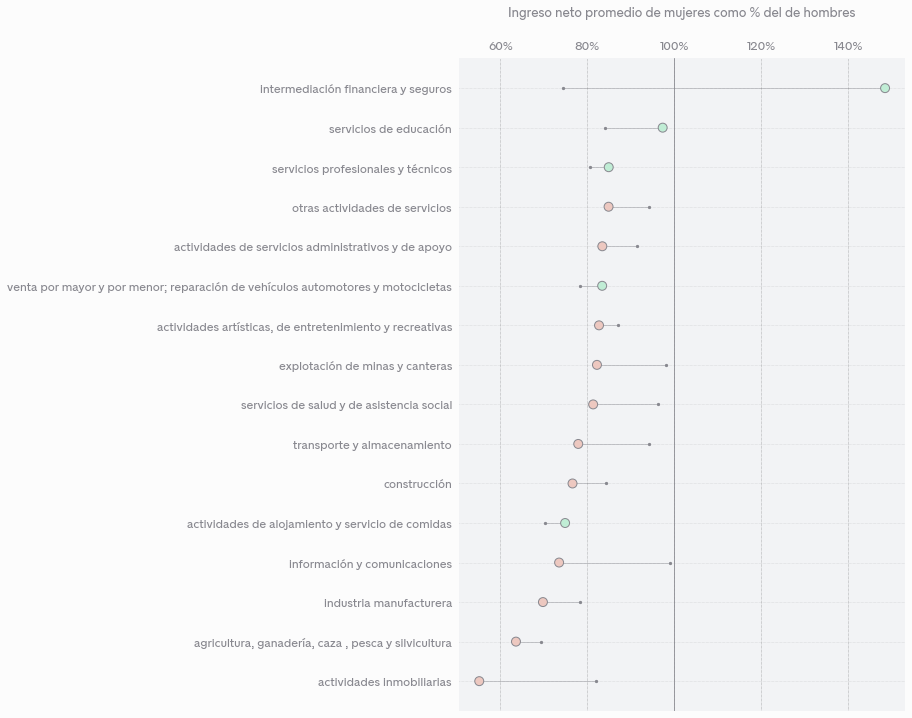

In [10]:
actividad_ocupacion = pd.Series({i: di.value_counts().index[0] for i, di in df[(df.ocupacion.notna()) & (df.actividad.notna())].groupby('ocupacion').actividad}).to_dict()

def diferencia_sexo_actividades():
    dfi = pd.concat([diferencia_sexo(y, 10).diferencia for y in [range(2015, 2018), range(2018, 2021)]], axis=1).dropna()
    dfi.columns = ['d1', 'd2']
    dfi.insert(0, 'actividad', dfi.index.map(actividad_ocupacion))
    return dfi.groupby('actividad')[['d1', 'd2']].mean()

def plot_diferencia_actividades():
    
    dfi = diferencia_sexo_actividades()
    
    lincolor = '#88888f'
    background = '#fcfcfc'
    colores = {False: '#edc8c0', True: '#c0edd5'}
    
    diferencia_sexo_actividades()
    dfi['mejora'] = dfi.d2 > dfi.d1
    dfi = dfi.sort_values('d2')
    
    f, ax = plt.subplots(1,1,figsize=(8,12))
    f.set_facecolor(background)
    
    for col, size, color in zip(['d1', 'd2'], [5, 80], [lincolor, dfi.mejora.map(colores)]):
        ax.scatter(dfi[col], dfi.index, color=color, zorder=2, edgecolor=lincolor, s=size)
    
    for ii, (i, row) in enumerate(dfi.iterrows()):
        ax.plot([row.d1, row.d2], [ii] * 2, color=lincolor, linestyle='-', linewidth=.8, alpha=.5, zorder=1)
    
    ax.grid(axis='x', zorder=1, alpha=.8)
    ax.grid(axis='y', zorder=1, alpha=.3)
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.axvline(x=1, linewidth=.8, color=lincolor)
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    ax.annotate('Ingreso neto promedio de mujeres como % del de hombres', xy=(.5, 1.06), xycoords='axes fraction', color=lincolor, ha='center', va='bottom', fontsize=13)

plot_diferencia_actividades()

**Estas condiciones están mejorando para mujeres jóvenes ingresando al mercado laboral**. La próxima gráfica ilustra la diferencia de ingresos entre sexos para grupos de edad de 5 años en la población de 26 a 70 años. Considero sólo casos donde el tamaño de la muestra (grupos de individuos con una combinación de rango etario + ocupación + sexo) sea al menos 5 individuos. Calculo la el ingreso promedio neto de mujeres como porcentaje del de hombres para cada caso y promedio estos resultados por rango de edad. En el gráfico, los puntos verdes muestran la media y las líneas la desviación estándar, para cada rango etario.

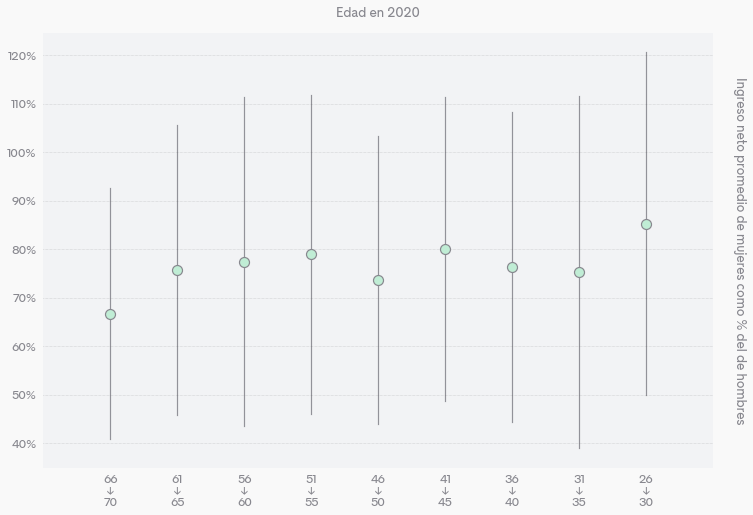

In [12]:
def ocupaciones_edad_sexo():

    desde = '1929-12-31'
    hasta = '1999-12-31'
    freq = '5Y'
    tamaños = df[(df.nacimiento > desde) & (df.nacimiento < hasta) & (df.ocupacion.notna()) & df.ingreso.notna()].groupby([pd.Grouper(key='nacimiento', freq=freq, label='left'), 'ocupacion', 'sexo']).size()
    tamaños = tamaños.reset_index(name='muestra')
    tamaños = tamaños.pivot_table(index=['nacimiento', 'ocupacion'], columns='sexo', values='muestra')
    filtro = tamaños[(tamaños >= 5).sum(axis=1) == 2].index 

    dfi = df[(df.nacimiento > desde) & (df.nacimiento < hasta) & (df.ocupacion.notna()) & df.ingreso.notna()].groupby([pd.Grouper(key='nacimiento', freq=freq, label='left'), 'ocupacion', 'sexo']).ingreso.mean()
    dfi = dfi.reset_index(name='muestra')
    dfi = dfi.pivot_table(index=['nacimiento', 'ocupacion'], columns='sexo', values='muestra')
    dfi = dfi.dropna()
    dfi = dfi.loc[filtro]
    dfi = dfi.reset_index()
    dfi = dfi[dfi.nacimiento.isin(dfi.nacimiento.value_counts()[dfi.nacimiento.value_counts() > 5].index)]

    dfi['diferencia_ingreso'] = dfi.mujer / dfi.hombre
    dfi['años'] = 2020 - pd.to_datetime(dfi.nacimiento).dt.year
    
    return dfi

def plot_ocupaciones_edad_sexo():
    
    lincolor = '#88888f'
    
    dfi = ocupaciones_edad_sexo()
    dfi2 = dfi.pivot_table(index='ocupacion', columns='años', values='diferencia_ingreso')[reversed(range(30,75,5))]
    dfi2 = pd.concat([dfi2.mean(), dfi2.std()], axis=1).rename(columns={0:'media', 1:'desviacion'})

    f, ax = plt.subplots(1,1,figsize=(12,8))
    ax.scatter(dfi2.index, dfi2.media, color='#c0edd5', edgecolor=lincolor, s=100, zorder=2, linewidth=1.2)
    for i, row in dfi2.iterrows():
        ax.plot([i] * 2, [row.media - row.desviacion, row.media + row.desviacion], color=lincolor, linestyle='-', linewidth=1.2, alpha=.9, zorder=1)

    ax.set_xlim(75, 25)
    ax.grid(axis='y')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1,0))
    ax.xaxis.set_major_locator(ticker.FixedLocator(dfi2.index))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(['{}\n↓\n{}'.format(i-4, i) for i in dfi2.index]))
    ax.tick_params(labelcolor=lincolor)
    ax.annotate('Ingreso neto promedio de mujeres como % del de hombres', xy=(1.03, .5), xycoords='axes fraction', fontsize=13, alpha=1., color=lincolor, ha='left', va='center', rotation=270)
    ax.annotate('Edad en 2020', xy=(.5, 1.03), xycoords='axes fraction', fontsize=13, alpha=1., color=lincolor, ha='center', va='bottom')
    
plot_ocupaciones_edad_sexo()